#### instalação e caminhos

In [ ]:
pip install pdfplumber

In [2]:
import pandas as pd
import pdfplumber

In [6]:
contratos_adt = '/content/contratos_adt.pdf'
objetos = '/content/objetos.pdf'

#### Objeto

In [7]:
#carregando arquivo
pdf = pdfplumber.open(objetos)

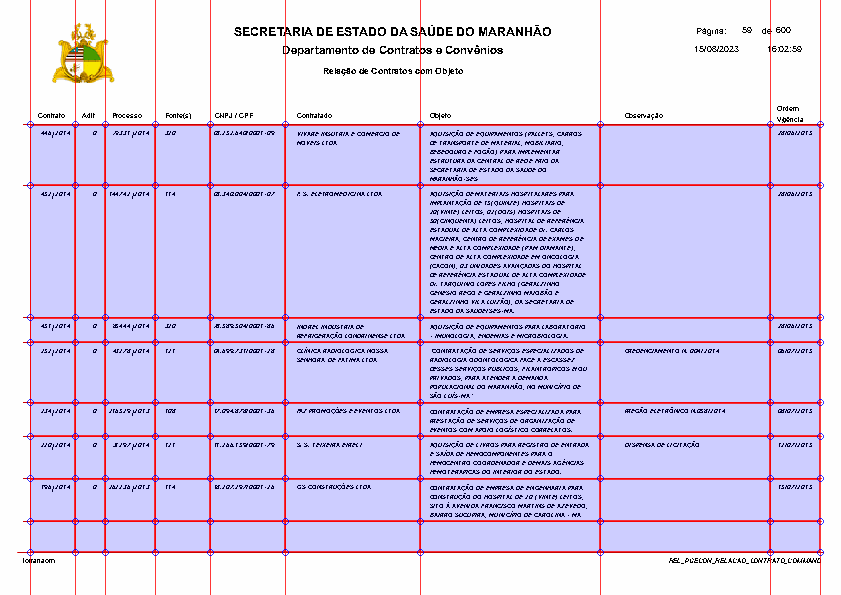

In [8]:
table_settings_objeto = {
    "vertical_strategy": "explicit",
    "horizontal_strategy":  "lines",
    "explicit_vertical_lines": [30,75,105,155,210,285,420,600,770,820]
}

p0 = pdf.pages[58]
im = p0.to_image()
im.reset().debug_tablefinder(table_settings_objeto)

In [ ]:
colunas = ["Contrato", "Aditivo", "Processo", "Fonte", "CNPJ/CPF", "Contratado", "Objeto", "Observação", "Ordem vigência"]

In [ ]:
base_objeto = pd.DataFrame()
for page in pdf.pages:
  texto = page.extract_table(table_settings_objeto)
  try:
    texto = [[elemento.replace('\n', ' ') for elemento in dentro_texto] for dentro_texto in texto]#removendo \n dentro das listas dentro de listas
  except:
    texto = texto
  dados = pd.DataFrame(texto, columns=colunas)
  base_objeto = pd.concat([base_objeto, dados], ignore_index=True)

In [ ]:
base_objeto['Objeto'] = base_objeto['Objeto'].replace({'"':""}, regex = True)
filtro_objeto_vazias = base_objeto['Contrato'] != ""
base_objeto = base_objeto[filtro_objeto_vazias]
base_objeto.reset_index(drop=True, inplace=True)
base_objeto['Ordem vigência'] = pd.to_datetime(base_objeto['Ordem vigência'], format='%d/%m/%Y')
base_objeto['Processo'] = base_objeto['Processo'].str.lstrip("0")

In [ ]:
base_objeto.to_excel("base_objeto_tratada.xlsx", index=False)

#### Aditivos

In [9]:
#carregando arquivo
pdf = pdfplumber.open(contratos_adt)

In [ ]:
colunas_adt = ['Contrato','adt','Nº Processo','Ord.', 'Tipo Aditivo','Data Aditivo',
  'Inicio Vig.','Fim Vigência','Valor Aditivo','Valor Global','Valor Mensal']

colunas_adt_datas =  ['Data Aditivo','Inicio Vig.','Fim Vigência']

colunas_adt_valor = ['Valor Aditivo','Valor Global','Valor Mensal']

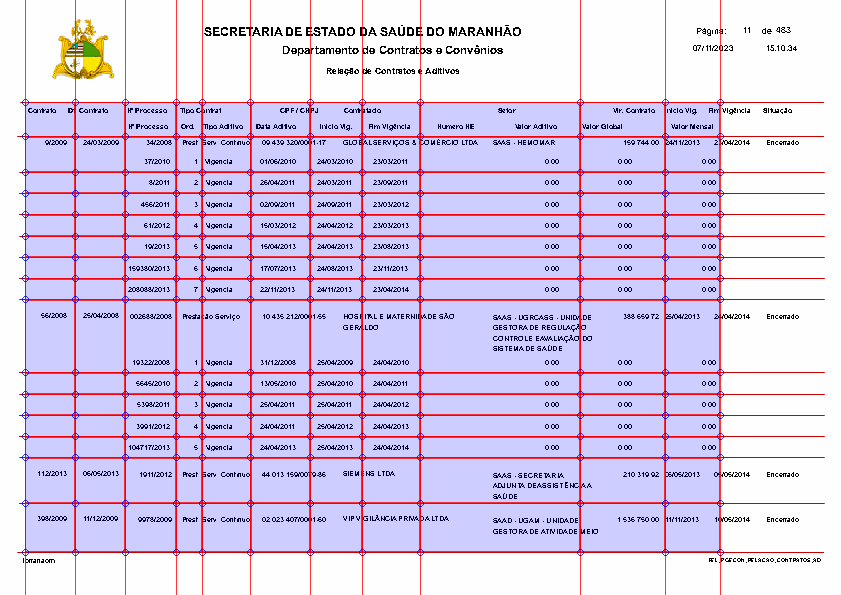

In [12]:
table_settings_aditivo = {
    "vertical_strategy": "explicit",
    "horizontal_strategy": "lines", #lines,lines_strict,text,explicit
    "explicit_vertical_lines": [25,75,125,176,202,250.5,310,362,420,580,665,720]
    }

p0 = pdf.pages[10]
im = p0.to_image()
im.reset().debug_tablefinder(table_settings_aditivo)

In [ ]:
base_aditivos = pd.DataFrame()
for page in pdf.pages:
  texto = page.extract_table(table_settings_aditivo)
  dados = pd.DataFrame(texto[1:], columns=colunas_adt)
  base_aditivos = pd.concat([base_aditivos, dados], ignore_index=True)

In [ ]:
base_aditivos['adt'] = base_aditivos['adt'].replace("","adt")
base_aditivos['Contrato'] = base_aditivos['Contrato'].replace("",pd.NA)
base_aditivos['Contrato'] = base_aditivos['Contrato'].ffill()

filtrando somente os aditivos do dataframe e removendo as "sujeiras" das linhas com informações de contratos

In [ ]:
filtro = base_aditivos['adt'].str.contains("adt", case=False) | base_aditivos['Ord.'].str.contains("1", case=False)
aditivos = base_aditivos[filtro]
aditivos.reset_index(inplace=True, drop=True)

In [ ]:
for i in range(len(aditivos)):#i será as linhas

  conteudo = aditivos.loc[i,"Ord."].split("\n")
  if len(conteudo) > 1:
    for k in range(2,len(aditivos.columns)):#k será as colunas
      celula = aditivos.iat[i,k].split("\n")
      aditivos.iat[i,k] = celula.pop()

  if aditivos['Tipo Aditivo'][i] == 'Valor' or aditivos['Tipo Aditivo'][i] == 'Entrega' or aditivos[
      'Tipo Aditivo'][i] == '':#removendo sujeira nas colunas

    aditivos.at[i, 'Inicio Vig.'] = pd.NaT
    aditivos.at[i, 'Fim Vigência'] = pd.NaT

  if 'NE' in aditivos['Valor Aditivo'][i]:
    celula = aditivos.at[i,'Valor Aditivo'].split()
    aditivos.at[i,'Valor Aditivo'] = celula.pop()

aditivos.drop(columns='adt', inplace = True)
filtro2 = aditivos['Nº Processo']!=''
aditivos = aditivos[filtro2]
aditivos['Nº Processo'] = aditivos['Nº Processo'].str.lstrip("0")
aditivos.reset_index(inplace=True, drop=True)

In [ ]:
for colunas in colunas_adt_datas:
  aditivos[colunas] = pd.to_datetime(aditivos[colunas], format='%d/%m/%Y', errors='coerce')

for colunas in colunas_adt_valor:
  aditivos[colunas] = aditivos[colunas].replace({'\.': '', ',': '.'}, regex=True)
  aditivos[colunas] = pd.to_numeric(aditivos[colunas])

In [ ]:
aditivos.to_excel('aditivos.xlsx', index = False)

## contrato

In [14]:
#carregando arquivo
pdf = pdfplumber.open(contratos_adt)

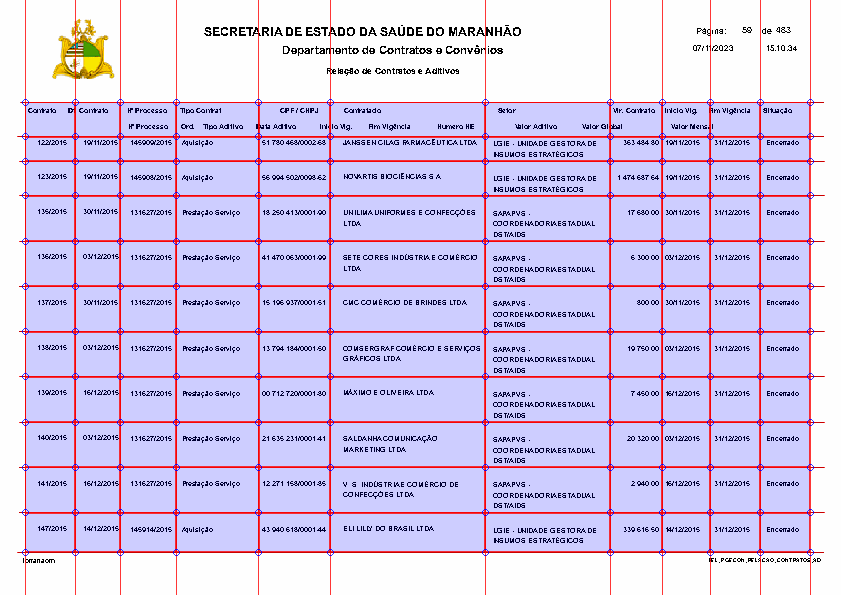

In [16]:
table_settings_contrato = {
    "vertical_strategy": "explicit",
    "horizontal_strategy": "lines_strict", #lines,lines_strict,text,explicit
    "explicit_vertical_lines": [25,75,120,176,258.5,330,485,610,662,710,760,810],
    }
#para visualização das linhas
p0 = pdf.pages[58]
im = p0.to_image()
im.reset().debug_tablefinder(table_settings_contrato)

In [ ]:
colunas_contrato = ['Contrato', 'Dt. Contrato', 'Nº Processo', 'Tipo Contrat', 'CPF/CNPJ', 'Contratado', 'Setor',
                    'Vlr. Contrato', 'Inicio Vig.', 'Fim Vigência', 'Situação']

colunas_dual = ['Nº Processo', 'Tipo Contrat', 'CPF/CNPJ',
       'Vlr. Contrato', 'Inicio Vig.', 'Fim Vigência',]

colunas_datas = ['Dt. Contrato','Inicio Vig.', 'Fim Vigência']

In [ ]:
contratos = pd.DataFrame()
for page in pdf.pages:
  texto = page.extract_table(table_settings_contrato)
  dados = pd.DataFrame(texto[1:], columns=colunas_contrato)
  contratos = pd.concat([contratos, dados], ignore_index=True)

In [ ]:
filtro_contrato = contratos['Contrato'] != ''
contratos = contratos[filtro_contrato]
contratos.reset_index(drop=True, inplace=True)

In [ ]:
for i in range(len(contratos)):

  conteudo = contratos.loc[i,'Tipo Contrat'].split('\n')

  if len(conteudo) > 1:
    for colunas in colunas_dual:
      contratos.at[i, colunas] = contratos[colunas][i].split()[0]

    #contratado
    conteudo = contratos['Contratado'][i].split()
    contratos.at[i,'Contratado'] = " ".join(conteudo[0:-2])
    #setor
    conteudo = contratos['Setor'][i].split()
    contratos.at[i,'Setor'] = " ".join(conteudo[0:-1])

contratos['Nº Processo'] = contratos['Nº Processo'].str.lstrip("0")#removendo 0 do início dos processos

In [ ]:
for colunas in colunas_datas:
  contratos[colunas]=pd.to_datetime(contratos[colunas], format='%d/%m/%Y')

contratos['Vlr. Contrato'] = contratos['Vlr. Contrato'].replace({'\.': '', ',': '.'}, regex=True)
contratos['Vlr. Contrato'] = pd.to_numeric(contratos['Vlr. Contrato'])

In [ ]:
contratos = contratos.replace({'\n':' '}, regex = True)

In [ ]:
contratos.to_excel('contratos.xlsx', index = False)